In [32]:
# Import Libraries
import os
import sys

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
from uncertainties import ufloat
import warnings


# Add the src directory to the path to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import parse_sample_pits


In [33]:
# Parse all snowpit files from the data folder
all_pits = parse_sample_pits('data')


Successfully parsed 50278 files
Failed to parse 0 files


In [34]:
# Collect General Pit Info
pit_info = []

for pit in all_pits:
    pit_info_dict = {
        # User info
        'pit_id': pit.core_info.pit_id,
        # Location info
        'pit_near_avalanche': pit.core_info.location.pit_near_avalanche,
        'pit_near_avalanche_location': pit.core_info.location.pit_near_avalanche_location if pit.core_info.location.pit_near_avalanche_location else None,
        # Weak Layer
        'identified_layer_of_concern': any(layer.layer_of_concern is True for layer in pit.snow_profile.layers) if pit.snow_profile.layers else None,
        # Stability Tests
        'num_CT': len(pit.stability_tests.CT),
        'num_ECT': len(pit.stability_tests.ECT),
        'num_PST': len(pit.stability_tests.PST),
        # Snowpit info

    }
    pit_info.append(pit_info_dict)
    
pit_df = pd.DataFrame(pit_info)

#print(pit_df.head())


In [35]:
## Summary Stats

# Total Pits
print(f"Total Pits: {len(pit_df)}")

# Number of Pits Near Avalanches
pits_near_avalanches = pit_df[(pit_df['pit_near_avalanche'] == True)]
print(f"Number of Pits Near Avalanches: {len(pits_near_avalanches)}")

# Number of Pits on Crowns
pits_on_crowns = pit_df[pit_df['pit_near_avalanche_location'] == 'crown']
print(f"Number of Pits on Crowns: {len(pits_on_crowns)}")

# Number of Pits on Flanks
pits_on_flanks = pit_df[pit_df['pit_near_avalanche_location'] == 'flank']
print(f"Number of Pits on Flanks: {len(pits_on_flanks)}")

# Number of Pits on Crowns and Flanks
print(f"Number of Pits on Crowns and Flanks: {len(pits_on_crowns) + len(pits_on_flanks)}")

# Number of pits with identified layer of concern
pits_with_layer_of_concern = pit_df[pit_df['identified_layer_of_concern'] == True]
print(f"Number of pits with identified layer of concern: {len(pits_with_layer_of_concern)}")

# Number of Pits with CT results
pits_with_CT_results = pit_df[pit_df['num_CT'] > 0]
print(f"Number of Pits with CT results: {len(pits_with_CT_results)}")

# Number of CT results 
print(f"Number of CT results: {sum(pit_df['num_CT'])}")

# Number of Pits with ECT results
pits_with_ECT_results = pit_df[pit_df['num_ECT'] > 0]
print(f"Number of Pits with ECT results: {len(pits_with_ECT_results)}")

# Number of ECT results
print(f"Number of ECT results: {sum(pit_df['num_ECT'])}")

# Number of Pits with PST results
pits_with_PST_results = pit_df[pit_df['num_PST'] > 0]
print(f"Number of Pits with PST results: {len(pits_with_PST_results)}")

# Number of PST results
print(f"Number of PST results: {sum(pit_df['num_PST'])}")


Total Pits: 50278
Number of Pits Near Avalanches: 1568
Number of Pits on Crowns: 795
Number of Pits on Flanks: 399
Number of Pits on Crowns and Flanks: 1194
Number of pits with identified layer of concern: 36408
Number of Pits with CT results: 28959
Number of CT results: 51599
Number of Pits with ECT results: 34327
Number of ECT results: 47684
Number of Pits with PST results: 5154
Number of PST results: 6213


## Efficient Dataset Construction and Analysis

This section constructs datasets efficiently and performs comprehensive analysis across all datasets.

In [36]:
def extract_layers_of_concern(pits, filter_location=None):
    """
    Efficiently extract all layers of concern from pits.
    
    Parameters:
    -----------
    pits : list
        List of pit objects
    filter_location : str, optional
        Filter by location: 'crown', 'flank', or None for all
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with layers of concern data
    """
    layers_of_concern = []
    
    for pit in pits:
        # Apply location filter if specified
        if filter_location:
            if pit.core_info.location.pit_near_avalanche_location != filter_location:
                continue
        
        # Extract all layers of concern from this pit
        if pit.snow_profile.layers:
            for layer in pit.snow_profile.layers:
                if layer.layer_of_concern is True:
                    loc_dict = {
                        'pit_id': pit.core_info.pit_id,
                        'dataset': filter_location if filter_location else 'all',
                        'depth_top': layer.depth_top[0] if layer.depth_top else None,
                        'thickness': layer.thickness[0] if layer.thickness else None,
                        'hardness': layer.hardness if layer.hardness else None,
                        'wetness': layer.wetness if layer.wetness else None,
                        'grain_form_primary_grain_form': layer.grain_form_primary.grain_form if layer.grain_form_primary else None,
                        'grain_from_primary_grain_size': layer.grain_form_primary.grain_size_avg[0] if layer.grain_form_primary and layer.grain_form_primary.grain_size_avg else None,
                        'grain_form_secondary_grain_form': layer.grain_form_secondary.grain_form if layer.grain_form_secondary else None,
                        'grain_from_secondary_grain_size': layer.grain_form_secondary.grain_size_avg[0] if layer.grain_form_secondary and layer.grain_form_secondary.grain_size_avg else None,
                    }
                    layers_of_concern.append(loc_dict)
    
    return pd.DataFrame(layers_of_concern)

# Construct all datasets efficiently
print("Constructing datasets...")
all_layers_df = extract_layers_of_concern(all_pits, filter_location=None)
crowns_layers_df = extract_layers_of_concern(all_pits, filter_location='crown')
flanks_layers_df = extract_layers_of_concern(all_pits, filter_location='flank')

# Combine all datasets with dataset labels for comparison
all_datasets_df = pd.concat([
    all_layers_df,
    crowns_layers_df,
    flanks_layers_df
], ignore_index=True)

print(f"All Identified Layers: {len(all_layers_df)}")
print(f"Crowns Layers: {len(crowns_layers_df)}")
print(f"Flanks Layers: {len(flanks_layers_df)}")
print(f"\nSample of combined data:")
print(all_datasets_df.head())


Constructing datasets...
All Identified Layers: 36409
Crowns Layers: 715
Flanks Layers: 356

Sample of combined data:
  pit_id dataset  depth_top  thickness hardness wetness  \
0  51686     all      105.0        5.0       F+    None   
1   5847     all        5.0        6.0        F       D   
2   9544     all       14.0       24.0       1F       W   
3  30734     all       90.0        3.0       I-       D   
4  43746     all        2.0       30.0       1F       D   

  grain_form_primary_grain_form  grain_from_primary_grain_size  \
0                          FCxr                            1.0   
1                            DF                            NaN   
2                          MFpc                            2.0   
3                          IFil                            NaN   
4                            DF                            0.5   

  grain_form_secondary_grain_form grain_from_secondary_grain_size  
0                              FC                            N

DEPTH STATISTICS COMPARISON
dataset  total_layers  layers_with_depth      mean  median    max  min       std
    all         36409              36409 49.347336    43.0 497.08  0.0 35.768390
  crown           715                715 65.480909    59.5 377.00  0.0 38.591858
  flank           356                356 54.031180    48.0 320.00  0.0 37.762505


/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_55919/804277480.py:55: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



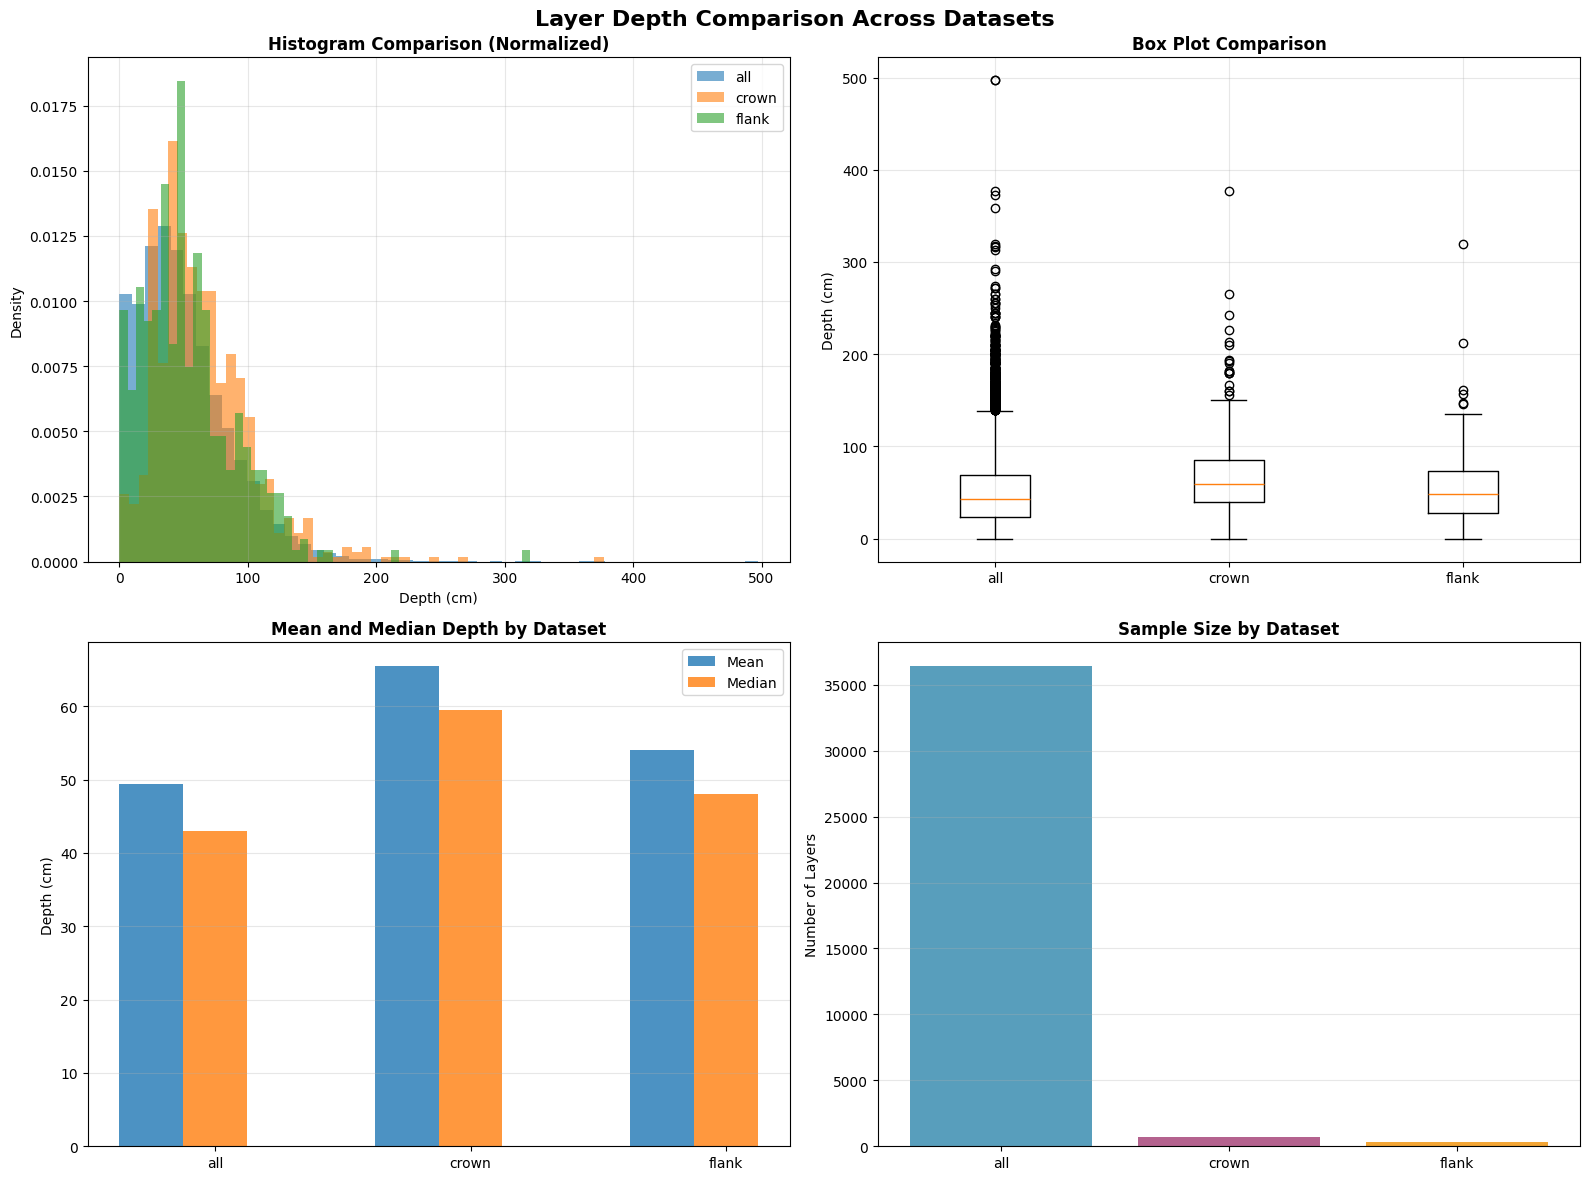

In [37]:
def analyze_depth(df, dataset_name):
    """Analyze depth statistics for a dataset."""
    valid_depth = df[df['depth_top'].notna()]['depth_top']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_depth': len(valid_depth),
        'mean': valid_depth.mean() if len(valid_depth) > 0 else None,
        'median': valid_depth.median() if len(valid_depth) > 0 else None,
        'max': valid_depth.max() if len(valid_depth) > 0 else None,
        'min': valid_depth.min() if len(valid_depth) > 0 else None,
        'std': valid_depth.std() if len(valid_depth) > 0 else None,
    }
    return stats, valid_depth

def compare_depth_across_datasets(all_datasets_df):
    """Compare depth statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank']
    }
    
    # Calculate statistics
    stats_list = []
    depth_data = {}
    for name, df in datasets.items():
        stats, depths = analyze_depth(df, name)
        stats_list.append(stats)
        depth_data[name] = depths
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("DEPTH STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Layer Depth Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Histogram comparison
    for name, depths in depth_data.items():
        if len(depths) > 0:
            axes[0, 0].hist(depths, bins=50, alpha=0.6, label=name, density=True)
    axes[0, 0].set_title('Histogram Comparison (Normalized)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Depth (cm)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Box plot comparison
    depth_list = [depths.values for depths in depth_data.values() if len(depths) > 0]
    labels_list = [name for name, depths in depth_data.items() if len(depths) > 0]
    axes[0, 1].boxplot(depth_list, labels=labels_list)
    axes[0, 1].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Depth (cm)')
    axes[0, 1].grid(alpha=0.3)
    
    # Statistics bar chart
    x = np.arange(len(stats_df))
    width = 0.25
    axes[1, 0].bar(x - width, stats_df['mean'], width, label='Mean', alpha=0.8)
    axes[1, 0].bar(x, stats_df['median'], width, label='Median', alpha=0.8)
    axes[1, 0].set_title('Mean and Median Depth by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Depth (cm)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(stats_df['dataset'])
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    axes[1, 1].bar(stats_df['dataset'], stats_df['layers_with_depth'], alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[1, 1].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Layers')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
depth_stats = compare_depth_across_datasets(all_datasets_df)


THICKNESS STATISTICS COMPARISON
dataset  total_layers  layers_with_thickness      mean  median   max  min       std
    all         36409                  36409 13.085122     8.0 250.0 0.01 14.427496
  crown           715                    715  9.813776     5.0 111.0 0.10 12.696035
  flank           356                    356 13.051124     8.0  80.0 0.10 14.226350


/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_55919/3440928895.py:55: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



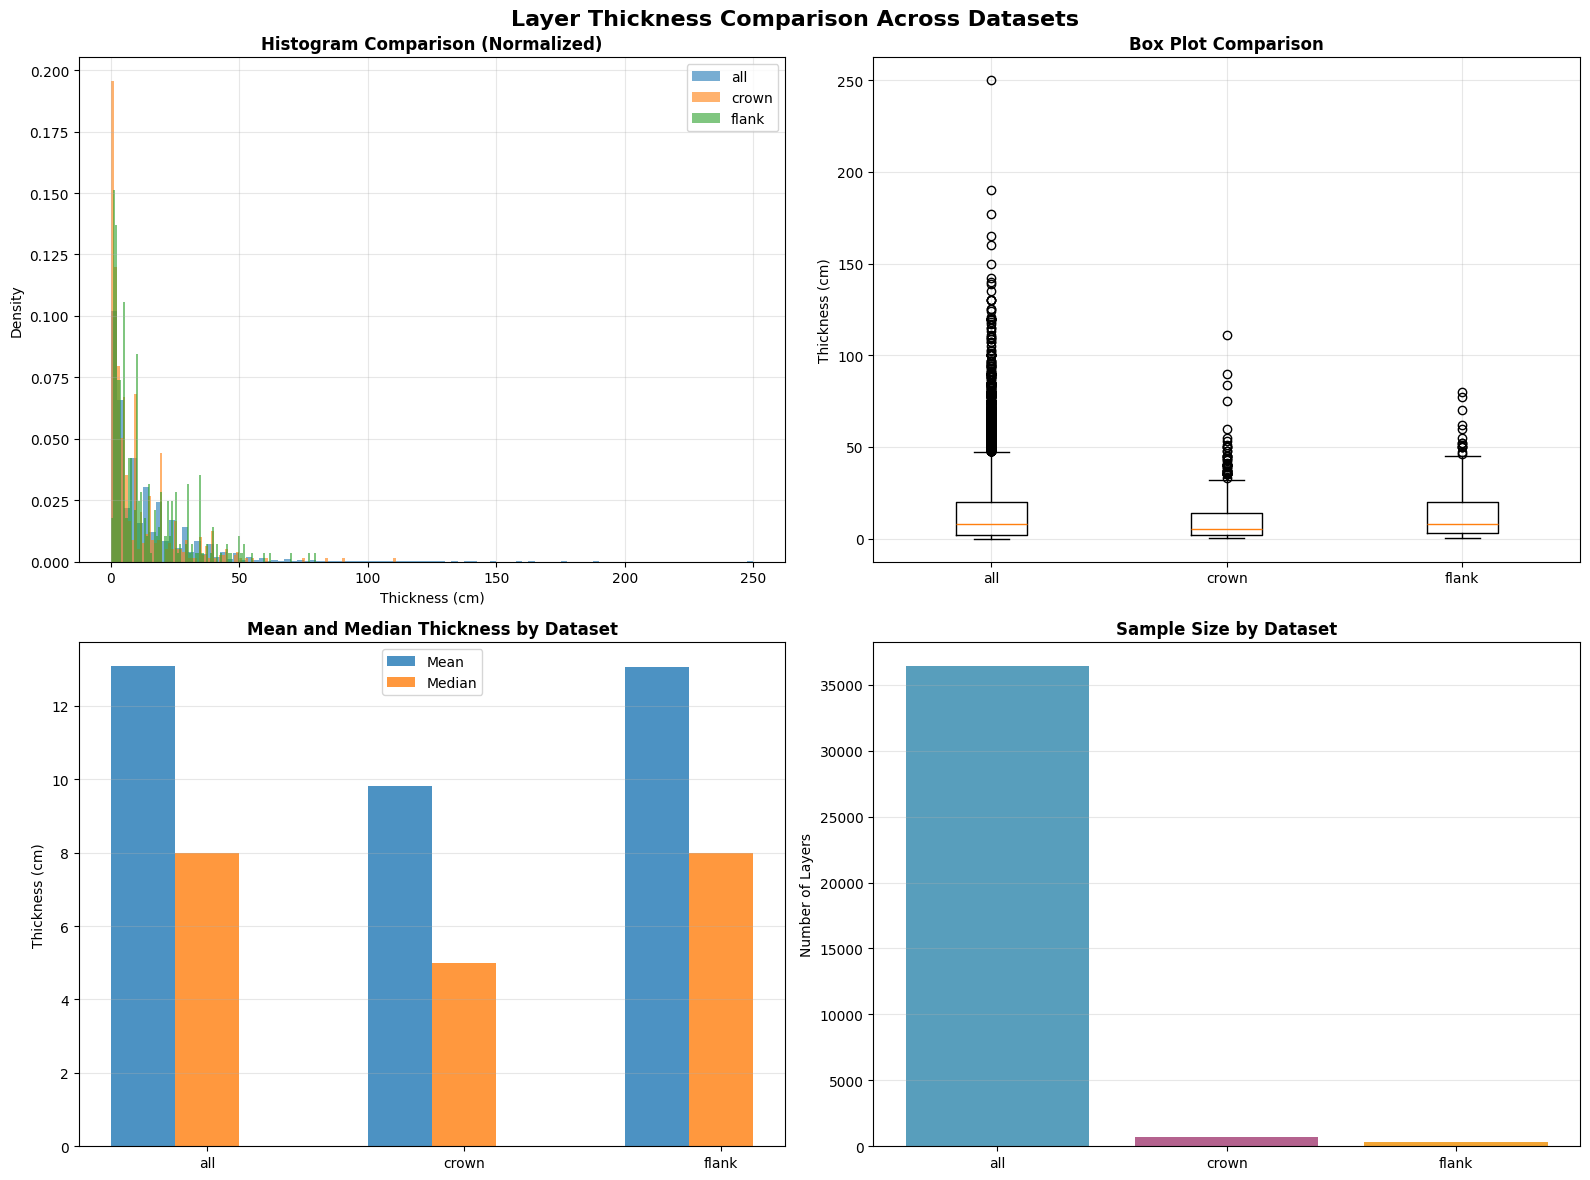

In [38]:
def analyze_thickness(df, dataset_name):
    """Analyze thickness statistics for a dataset."""
    valid_thickness = df[df['thickness'].notna()]['thickness']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_thickness': len(valid_thickness),
        'mean': valid_thickness.mean() if len(valid_thickness) > 0 else None,
        'median': valid_thickness.median() if len(valid_thickness) > 0 else None,
        'max': valid_thickness.max() if len(valid_thickness) > 0 else None,
        'min': valid_thickness.min() if len(valid_thickness) > 0 else None,
        'std': valid_thickness.std() if len(valid_thickness) > 0 else None,
    }
    return stats, valid_thickness

def compare_thickness_across_datasets(all_datasets_df):
    """Compare thickness statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank']
    }
    
    # Calculate statistics
    stats_list = []
    thickness_data = {}
    for name, df in datasets.items():
        stats, thicknesses = analyze_thickness(df, name)
        stats_list.append(stats)
        thickness_data[name] = thicknesses
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("THICKNESS STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Layer Thickness Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Histogram comparison
    for name, thicknesses in thickness_data.items():
        if len(thicknesses) > 0:
            axes[0, 0].hist(thicknesses, bins=100, alpha=0.6, label=name, density=True)
    axes[0, 0].set_title('Histogram Comparison (Normalized)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Thickness (cm)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Box plot comparison
    thickness_list = [thicknesses.values for thicknesses in thickness_data.values() if len(thicknesses) > 0]
    labels_list = [name for name, thicknesses in thickness_data.items() if len(thicknesses) > 0]
    axes[0, 1].boxplot(thickness_list, labels=labels_list)
    axes[0, 1].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Thickness (cm)')
    axes[0, 1].grid(alpha=0.3)
    
    # Statistics bar chart
    x = np.arange(len(stats_df))
    width = 0.25
    axes[1, 0].bar(x - width, stats_df['mean'], width, label='Mean', alpha=0.8)
    axes[1, 0].bar(x, stats_df['median'], width, label='Median', alpha=0.8)
    axes[1, 0].set_title('Mean and Median Thickness by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Thickness (cm)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(stats_df['dataset'])
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    axes[1, 1].bar(stats_df['dataset'], stats_df['layers_with_thickness'], alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[1, 1].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Layers')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
thickness_stats = compare_thickness_across_datasets(all_datasets_df)


HARDNESS STATISTICS COMPARISON
dataset  total_layers  layers_with_hardness  percentage
    all         36409                 33114   90.950040
  crown           715                   662   92.587413
  flank           356                   326   91.573034

HARDNESS FREQUENCY BY DATASET

ALL:
hardness
F      9726
4F     7540
1F     3414
P      2138
4F-    1711
K      1540
F+     1498
F-     1285
4F+    1091
1F-     881
Name: count, dtype: int64

CROWN:
hardness
F      213
4F     153
4F-     63
1F      44
F-      34
F+      31
4F+     28
1F-     27
P       26
P-      12
Name: count, dtype: int64

FLANK:
hardness
F      104
4F      70
1F      34
4F-     24
F+      17
F-      15
P       15
4F+     13
K       11
1F+      6
Name: count, dtype: int64


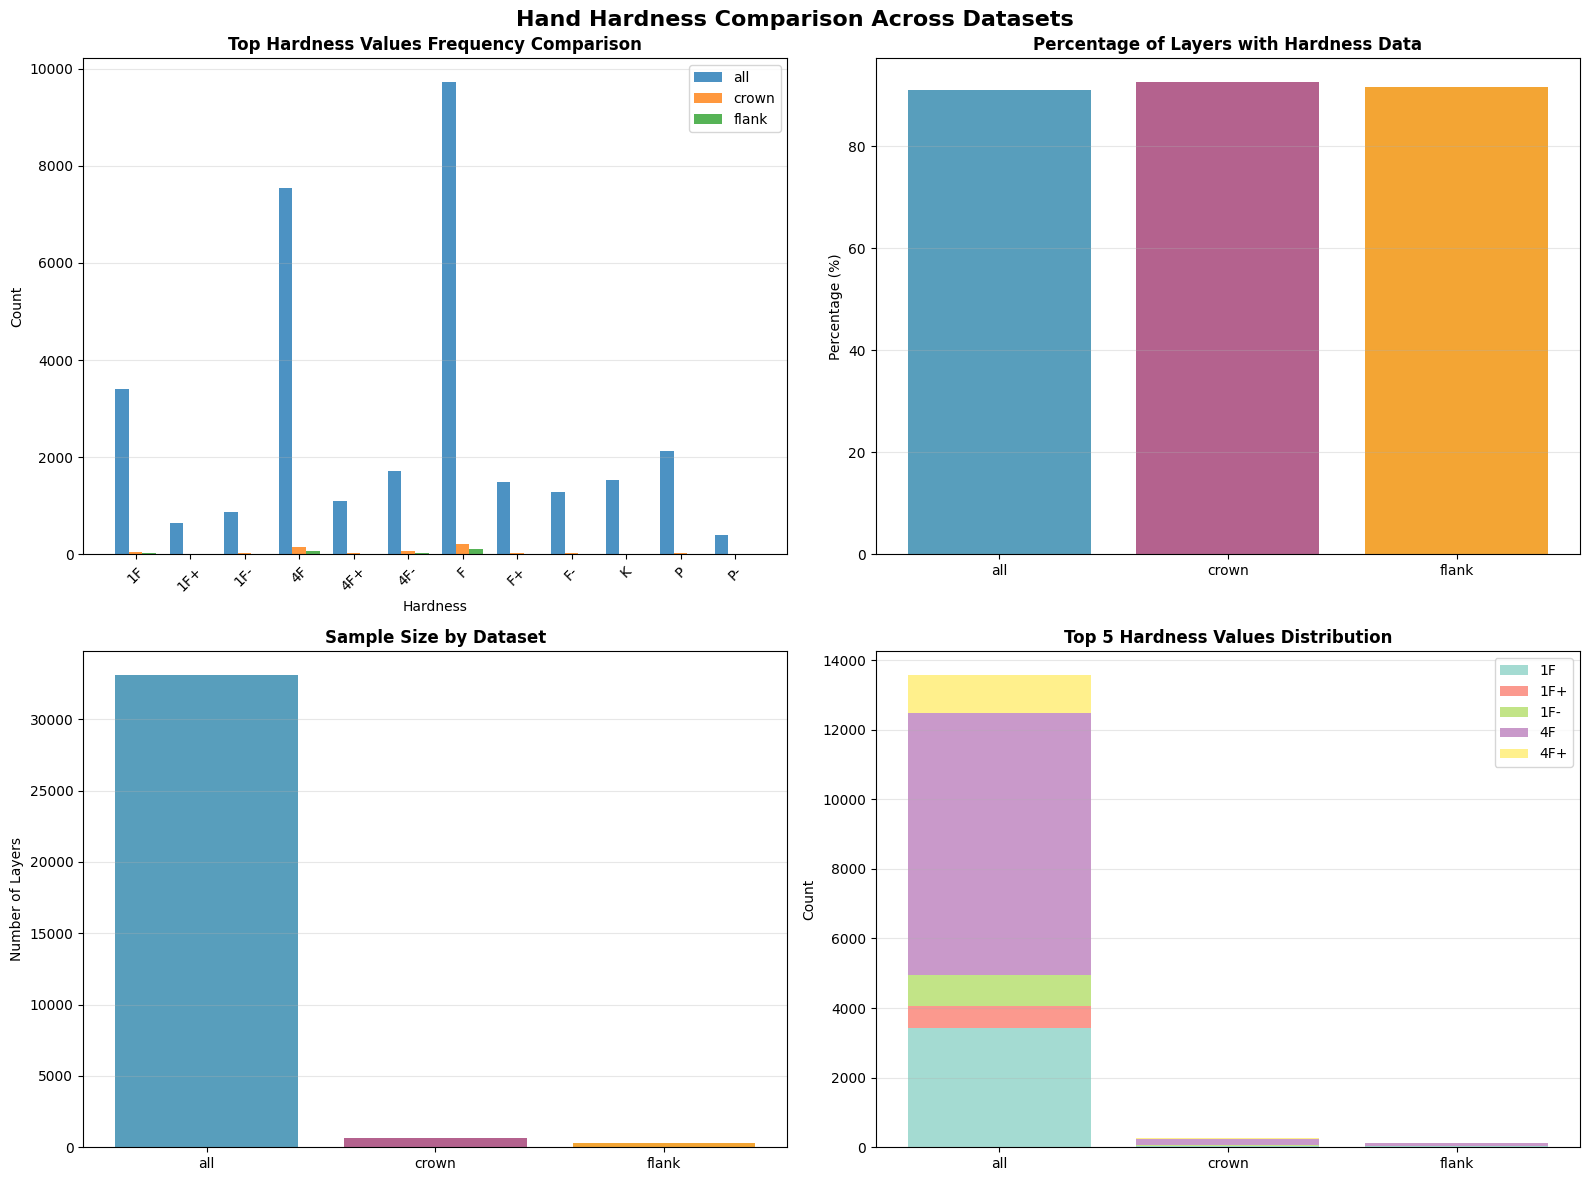

In [39]:
def analyze_hardness(df, dataset_name):
    """Analyze hardness statistics for a dataset."""
    valid_hardness = df[df['hardness'].notna()]['hardness']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_hardness': len(valid_hardness),
        'percentage': len(valid_hardness) / len(df) * 100 if len(df) > 0 else 0,
    }
    return stats, valid_hardness

def compare_hardness_across_datasets(all_datasets_df):
    """Compare hardness statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank']
    }
    
    # Calculate statistics
    stats_list = []
    hardness_data = {}
    for name, df in datasets.items():
        stats, hardnesses = analyze_hardness(df, name)
        stats_list.append(stats)
        hardness_data[name] = hardnesses
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("HARDNESS STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Frequency counts for each dataset
    print("\n" + "="*80)
    print("HARDNESS FREQUENCY BY DATASET")
    print("="*80)
    for name, hardnesses in hardness_data.items():
        if len(hardnesses) > 0:
            print(f"\n{name.upper()}:")
            print(hardnesses.value_counts().head(10))
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Hand Hardness Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Frequency comparison for top hardness values
    all_hardness_values = set()
    for hardnesses in hardness_data.values():
        all_hardness_values.update(hardnesses.value_counts().head(10).index)
    all_hardness_values = sorted(list(all_hardness_values))
    
    x = np.arange(len(all_hardness_values))
    width = 0.25
    for i, (name, hardnesses) in enumerate(hardness_data.items()):
        if len(hardnesses) > 0:
            counts = [hardnesses.value_counts().get(val, 0) for val in all_hardness_values]
            axes[0, 0].bar(x + i*width, counts, width, label=name, alpha=0.8)
    axes[0, 0].set_title('Top Hardness Values Frequency Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Hardness')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticks(x + width)
    axes[0, 0].set_xticklabels(all_hardness_values, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Percentage with hardness data
    axes[0, 1].bar(stats_df['dataset'], stats_df['percentage'], alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[0, 1].set_title('Percentage of Layers with Hardness Data', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    axes[1, 0].bar(stats_df['dataset'], stats_df['layers_with_hardness'], alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[1, 0].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Layers')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Stacked bar chart for top 5 hardness values
    top_hardness = sorted(all_hardness_values)[:5]
    bottom = np.zeros(3)
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_hardness)))
    for i, hardness_val in enumerate(top_hardness):
        values = []
        for name in ['all', 'crown', 'flank']:
            if name in hardness_data and len(hardness_data[name]) > 0:
                values.append(hardness_data[name].value_counts().get(hardness_val, 0))
            else:
                values.append(0)
        axes[1, 1].bar(['all', 'crown', 'flank'], values, bottom=bottom, label=hardness_val, color=colors[i], alpha=0.8)
        bottom += values
    axes[1, 1].set_title('Top 5 Hardness Values Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
hardness_stats = compare_hardness_across_datasets(all_datasets_df)


WETNESS STATISTICS COMPARISON
dataset  total_layers  layers_with_wetness  percentage
    all         36409                 9378   25.757368
  crown           715                  165   23.076923
  flank           356                   98   27.528090

WETNESS FREQUENCY BY DATASET

ALL:
wetness
D      7154
M       998
D-M     647
M-W     225
W       224
V        60
W-V      32
S        19
V-S      19
Name: count, dtype: int64

CROWN:
wetness
D      143
M       12
D-M      7
M-W      2
V        1
Name: count, dtype: int64

FLANK:
wetness
D      70
D-M    10
W       8
M       6
M-W     2
W-V     1
V-S     1
Name: count, dtype: int64


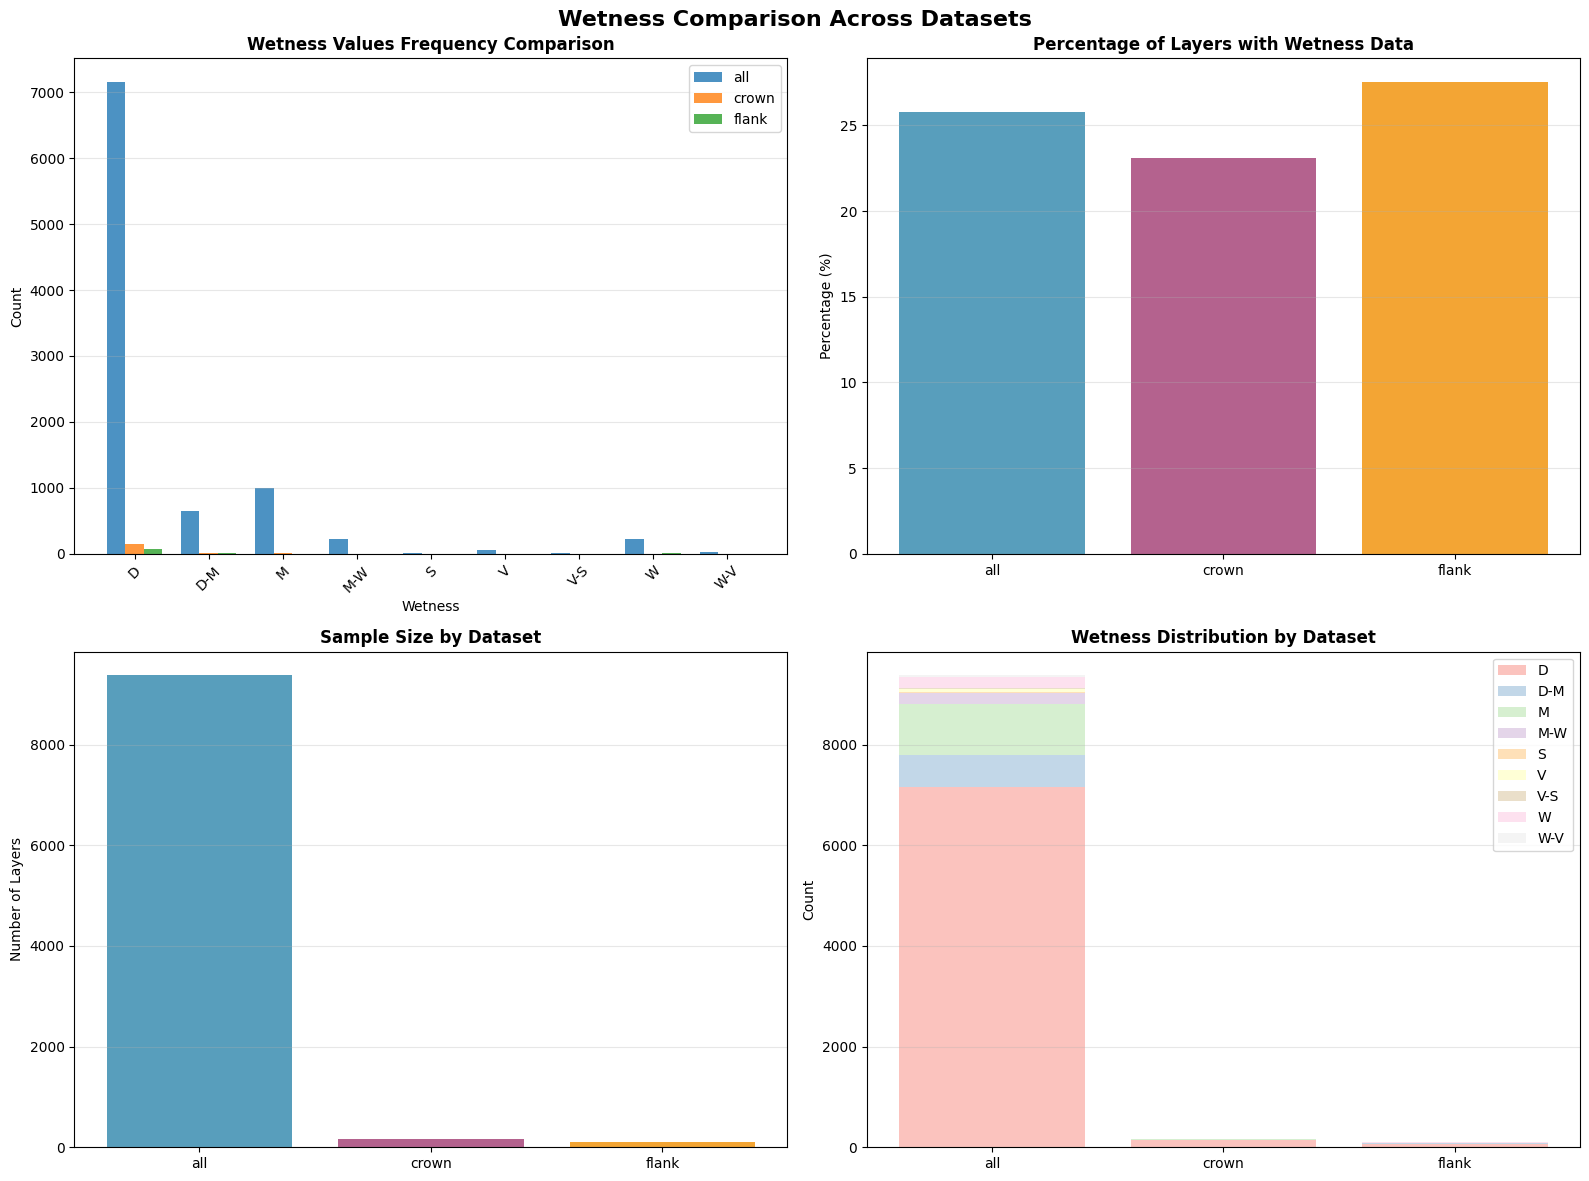

In [40]:
def analyze_wetness(df, dataset_name):
    """Analyze wetness statistics for a dataset."""
    valid_wetness = df[df['wetness'].notna()]['wetness']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_wetness': len(valid_wetness),
        'percentage': len(valid_wetness) / len(df) * 100 if len(df) > 0 else 0,
    }
    return stats, valid_wetness

def compare_wetness_across_datasets(all_datasets_df):
    """Compare wetness statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank']
    }
    
    # Calculate statistics
    stats_list = []
    wetness_data = {}
    for name, df in datasets.items():
        stats, wetnesses = analyze_wetness(df, name)
        stats_list.append(stats)
        wetness_data[name] = wetnesses
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("WETNESS STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Frequency counts for each dataset
    print("\n" + "="*80)
    print("WETNESS FREQUENCY BY DATASET")
    print("="*80)
    for name, wetnesses in wetness_data.items():
        if len(wetnesses) > 0:
            print(f"\n{name.upper()}:")
            print(wetnesses.value_counts())
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Wetness Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Frequency comparison for all wetness values
    all_wetness_values = set()
    for wetnesses in wetness_data.values():
        all_wetness_values.update(wetnesses.value_counts().index)
    all_wetness_values = sorted(list(all_wetness_values))
    
    x = np.arange(len(all_wetness_values))
    width = 0.25
    for i, (name, wetnesses) in enumerate(wetness_data.items()):
        if len(wetnesses) > 0:
            counts = [wetnesses.value_counts().get(val, 0) for val in all_wetness_values]
            axes[0, 0].bar(x + i*width, counts, width, label=name, alpha=0.8)
    axes[0, 0].set_title('Wetness Values Frequency Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Wetness')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticks(x + width)
    axes[0, 0].set_xticklabels(all_wetness_values, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Percentage with wetness data
    axes[0, 1].bar(stats_df['dataset'], stats_df['percentage'], alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[0, 1].set_title('Percentage of Layers with Wetness Data', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    axes[1, 0].bar(stats_df['dataset'], stats_df['layers_with_wetness'], alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[1, 0].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Layers')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Stacked bar chart for wetness distribution
    bottom = np.zeros(3)
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(all_wetness_values)))
    for i, wetness_val in enumerate(all_wetness_values):
        values = []
        for name in ['all', 'crown', 'flank']:
            if name in wetness_data and len(wetness_data[name]) > 0:
                values.append(wetness_data[name].value_counts().get(wetness_val, 0))
            else:
                values.append(0)
        axes[1, 1].bar(['all', 'crown', 'flank'], values, bottom=bottom, label=wetness_val, color=colors[i], alpha=0.8)
        bottom += values
    axes[1, 1].set_title('Wetness Distribution by Dataset', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
wetness_stats = compare_wetness_across_datasets(all_datasets_df)


GRAIN FORM STATISTICS COMPARISON
dataset  total_layers  layers_with_primary_grain_form  percentage_primary_grain_form  layers_with_primary_grain_size  percentage_primary_grain_size  layers_with_secondary_grain_form  percentage_secondary_grain_form
    all         36409                           33153                      91.057156                           22636                      62.171441                              6075                        16.685435
  crown           715                             679                      94.965035                             532                      74.405594                               134                        18.741259
  flank           356                             329                      92.415730                             233                      65.449438                                78                        21.910112

MAIN GRAIN FORM (FIRST 2 CHARACTERS) COMPARISON

ALL:
                 Count Percentage
main_grain_form   

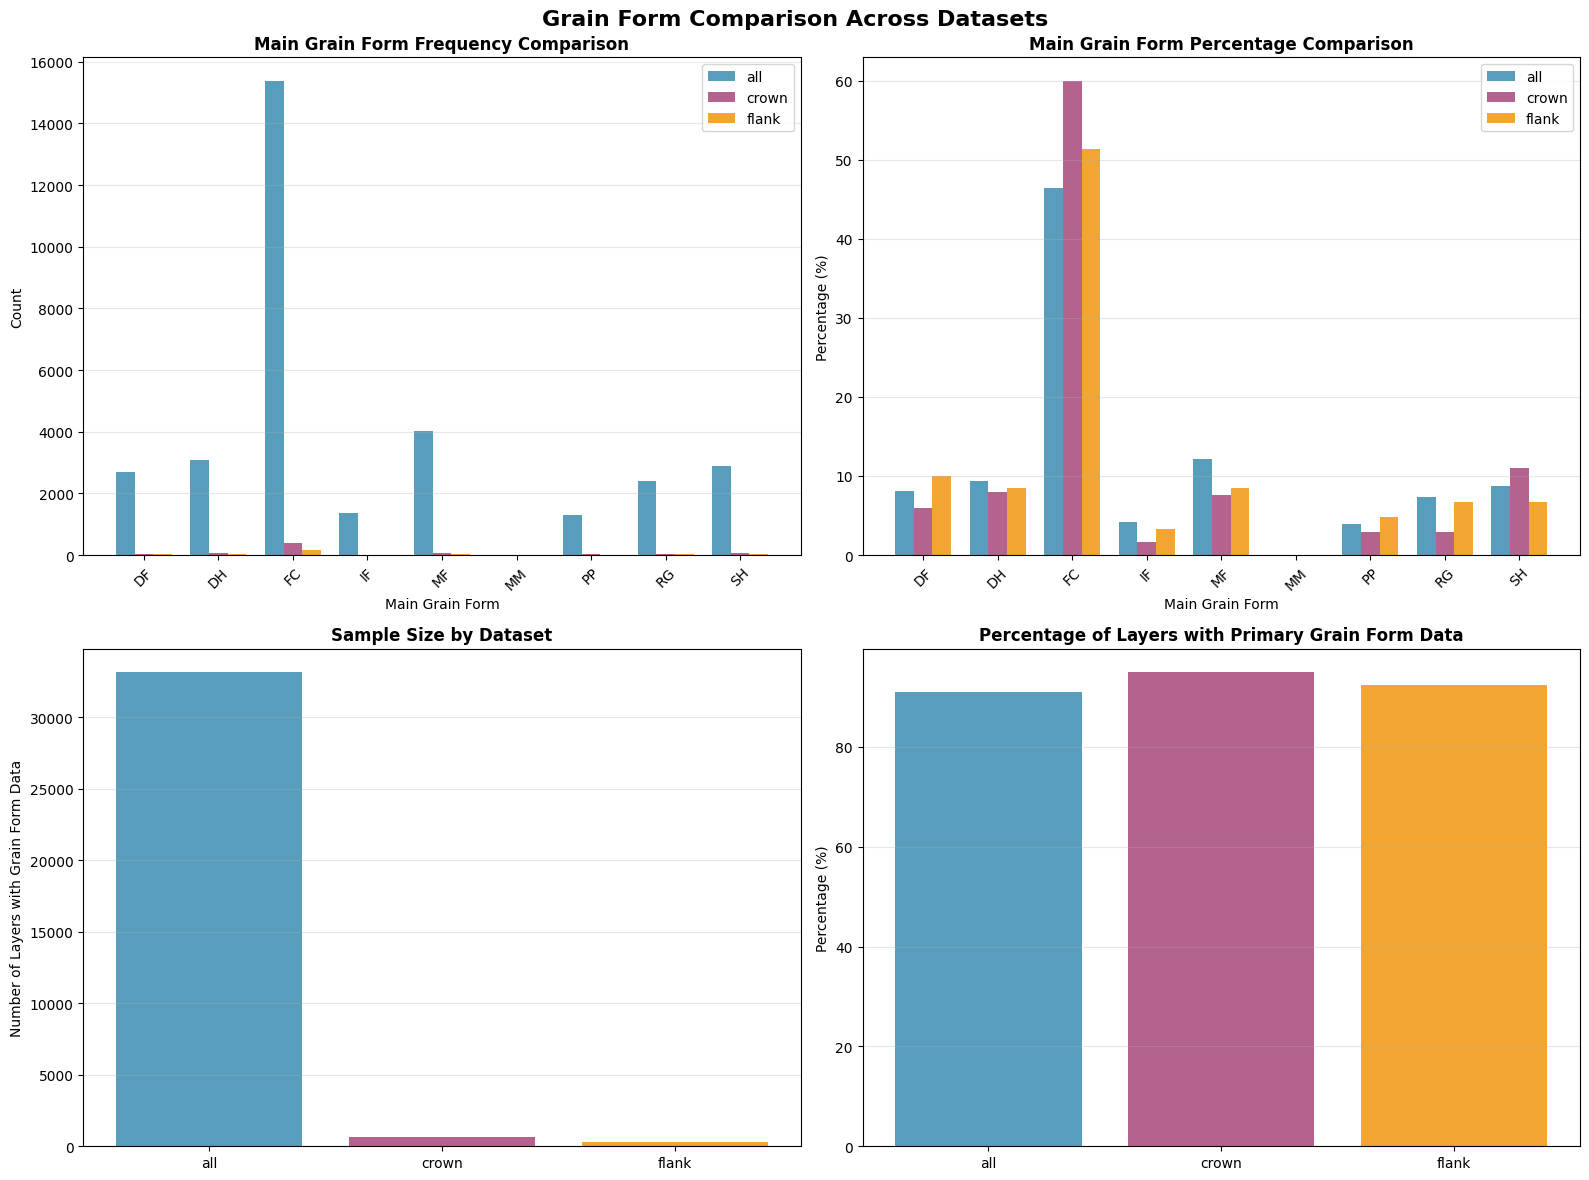


TREEMAP VISUALIZATION - ALL DATASETS


In [41]:
def analyze_grain_forms(df, dataset_name):
    """Analyze grain form statistics for a dataset."""
    valid_grain_form = df[df['grain_form_primary_grain_form'].notna()]
    valid_grain_size = df[df['grain_from_primary_grain_size'].notna()]
    valid_secondary = df[df['grain_form_secondary_grain_form'].notna()]
    
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_primary_grain_form': len(valid_grain_form),
        'percentage_primary_grain_form': len(valid_grain_form) / len(df) * 100 if len(df) > 0 else 0,
        'layers_with_primary_grain_size': len(valid_grain_size),
        'percentage_primary_grain_size': len(valid_grain_size) / len(df) * 100 if len(df) > 0 else 0,
        'layers_with_secondary_grain_form': len(valid_secondary),
        'percentage_secondary_grain_form': len(valid_secondary) / len(df) * 100 if len(df) > 0 else 0,
    }
    return stats, valid_grain_form

def compare_grain_forms_across_datasets(all_datasets_df):
    """Compare grain form statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank']
    }
    
    # Calculate statistics
    stats_list = []
    grain_form_data = {}
    for name, df in datasets.items():
        stats, valid_grain = analyze_grain_forms(df, name)
        stats_list.append(stats)
        grain_form_data[name] = valid_grain
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("GRAIN FORM STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Main grain form analysis (first 2 characters)
    print("\n" + "="*80)
    print("MAIN GRAIN FORM (FIRST 2 CHARACTERS) COMPARISON")
    print("="*80)
    
    # Calculate main grain form frequencies for each dataset
    main_grain_stats = {}
    for name, df in grain_form_data.items():
        if len(df) > 0:
            df_copy = df.copy()
            df_copy['main_grain_form'] = df_copy['grain_form_primary_grain_form'].str[:2]
            main_counts = df_copy['main_grain_form'].value_counts()
            main_percentages = df_copy['main_grain_form'].value_counts(normalize=True) * 100
            main_grain_stats[name] = {
                'counts': main_counts,
                'percentages': main_percentages
            }
            print(f"\n{name.upper()}:")
            main_stats_df = pd.DataFrame({
                'Count': main_counts,
                'Percentage': main_percentages
            })
            main_stats_df['Percentage'] = main_stats_df['Percentage'].apply(lambda x: f'{x:.2f}%')
            print(main_stats_df)
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Grain Form Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Get all main grain forms across datasets
    all_main_grain_forms = set()
    for stats in main_grain_stats.values():
        all_main_grain_forms.update(stats['counts'].index)
    all_main_grain_forms = sorted(list(all_main_grain_forms))
    
    # Side-by-side comparison of main grain forms
    x = np.arange(len(all_main_grain_forms))
    width = 0.25
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    for i, (name, stats) in enumerate(main_grain_stats.items()):
        counts = [stats['counts'].get(gf, 0) for gf in all_main_grain_forms]
        axes[0, 0].bar(x + i*width, counts, width, label=name, color=colors[i], alpha=0.8)
    axes[0, 0].set_title('Main Grain Form Frequency Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Main Grain Form')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticks(x + width)
    axes[0, 0].set_xticklabels(all_main_grain_forms, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Percentage comparison
    for i, (name, stats) in enumerate(main_grain_stats.items()):
        percentages = [stats['percentages'].get(gf, 0) for gf in all_main_grain_forms]
        axes[0, 1].bar(x + i*width, percentages, width, label=name, color=colors[i], alpha=0.8)
    axes[0, 1].set_title('Main Grain Form Percentage Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Main Grain Form')
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].set_xticks(x + width)
    axes[0, 1].set_xticklabels(all_main_grain_forms, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    axes[1, 0].bar(stats_df['dataset'], stats_df['layers_with_primary_grain_form'], 
                   alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[1, 0].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Layers with Grain Form Data')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Percentage with grain form data
    axes[1, 1].bar(stats_df['dataset'], stats_df['percentage_primary_grain_form'], 
                   alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[1, 1].set_title('Percentage of Layers with Primary Grain Form Data', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Percentage (%)')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Create treemap for all datasets combined
    print("\n" + "="*80)
    print("TREEMAP VISUALIZATION - ALL DATASETS")
    print("="*80)
    
    # Prepare data for hierarchical treemap
    treemap_data = []
    for name, df in grain_form_data.items():
        if len(df) > 0:
            df_copy = df.copy()
            df_copy['main_grain_form'] = df_copy['grain_form_primary_grain_form'].str[:2]
            grain_form_counts = df_copy['grain_form_primary_grain_form'].value_counts()
            
            for grain_form, count in grain_form_counts.items():
                main_form = grain_form[:2]
                treemap_data.append({
                    'dataset': name,
                    'main_grain_form': main_form,
                    'grain_form': grain_form,
                    'count': count
                })
    
    treemap_df = pd.DataFrame(treemap_data)
    
    # Create hierarchical treemap
    fig = px.treemap(
        treemap_df,
        path=['dataset', 'main_grain_form', 'grain_form'],
        values='count',
        title='Treemap of Primary Grain Forms by Dataset (Grouped by Main Grain Form Code)',
        color='dataset',
        color_discrete_map={'all': '#2E86AB', 'crown': '#A23B72', 'flank': '#F18F01'},
        height=800
    )
    
    fig.update_traces(
        textinfo='label+value',
        texttemplate='%{label}<br>%{value}',
        textfont_size=10,
        hovertemplate='<b>%{label}</b><br>Count: %{value}<extra></extra>'
    )
    
    fig.update_layout(
        font_size=12,
        title_font_size=16,
        title_x=0.5
    )
    
    fig.show()
    
    return stats_df, main_grain_stats

# Perform comparison analysis
grain_form_stats, main_grain_stats = compare_grain_forms_across_datasets(all_datasets_df)


## Summary of Analysis Results

The analysis above compares layers of concern across all datasets (all identified layers, pits on crowns, and pits on flanks). All analyses have been refactored to be efficient and provide direct comparisons across datasets.

In [42]:
# Summary statistics for datasets
print("="*80)
print("DATASET SUMMARY STATISTICS")
print("="*80)
print(f"\nAll Identified Layers of Concern: {len(all_layers_df)}")
print(f"Layers from Pits on Crowns: {len(crowns_layers_df)}")
print(f"Layers from Pits on Flanks: {len(flanks_layers_df)}")

# Calculate pit-level statistics
crown_pit_ids = set(crowns_layers_df['pit_id'].unique())
flank_pit_ids = set(flanks_layers_df['pit_id'].unique())
all_pit_ids = set(all_layers_df['pit_id'].unique())

print(f"\nUnique Pits with Layers of Concern:")
print(f"  All datasets: {len(all_pit_ids)}")
print(f"  Crowns: {len(crown_pit_ids)}")
print(f"  Flanks: {len(flank_pit_ids)}")
print(f"  Crowns and Flanks combined: {len(crown_pit_ids | flank_pit_ids)}")



DATASET SUMMARY STATISTICS

All Identified Layers of Concern: 36409
Layers from Pits on Crowns: 715
Layers from Pits on Flanks: 356

Unique Pits with Layers of Concern:
  All datasets: 36408
  Crowns: 715
  Flanks: 356
  Crowns and Flanks combined: 1071


In [43]:
# Additional pit-level summary from pit_df
print("\n" + "="*80)
print("PIT-LEVEL SUMMARY (from pit_df)")
print("="*80)
pits_on_crowns_pit_df = pit_df[pit_df['pit_near_avalanche_location'] == 'crown']
pits_on_flanks_pit_df = pit_df[pit_df['pit_near_avalanche_location'] == 'flank']

print(f"\nTotal Pits: {len(pit_df)}")
print(f"Number of Pits on Crowns: {len(pits_on_crowns_pit_df)}, {len(pits_on_crowns_pit_df)/len(pit_df):.2%}")
print(f"Number of Pits on Flanks: {len(pits_on_flanks_pit_df)}, {len(pits_on_flanks_pit_df)/len(pit_df):.2%}")
print(f"Number of Pits on Crowns and Flanks: {len(pits_on_crowns_pit_df) + len(pits_on_flanks_pit_df)}, {(len(pits_on_crowns_pit_df) + len(pits_on_flanks_pit_df))/len(pit_df):.2%}")

print("\nLayer of Concern Stats (Pit Level)")
crowns_with_loc = pits_on_crowns_pit_df[pits_on_crowns_pit_df['identified_layer_of_concern'] == True]
flanks_with_loc = pits_on_flanks_pit_df[pits_on_flanks_pit_df['identified_layer_of_concern'] == True]
print(f"Pits on Crowns with Layer of Concern: {len(crowns_with_loc)}, {len(crowns_with_loc)/len(pits_on_crowns_pit_df):.2%}" if len(pits_on_crowns_pit_df) > 0 else "Pits on Crowns with Layer of Concern: 0")
print(f"Pits on Flanks with Layer of Concern: {len(flanks_with_loc)}, {len(flanks_with_loc)/len(pits_on_flanks_pit_df):.2%}" if len(pits_on_flanks_pit_df) > 0 else "Pits on Flanks with Layer of Concern: 0")



PIT-LEVEL SUMMARY (from pit_df)

Total Pits: 50278
Number of Pits on Crowns: 795, 1.58%
Number of Pits on Flanks: 399, 0.79%
Number of Pits on Crowns and Flanks: 1194, 2.37%

Layer of Concern Stats (Pit Level)
Pits on Crowns with Layer of Concern: 715, 89.94%
Pits on Flanks with Layer of Concern: 356, 89.22%


In [44]:
# This cell has been replaced by the comprehensive grain form analysis above
# The grain form comparison is now included in the compare_grain_forms_across_datasets function
# which provides side-by-side comparisons across all three datasets (all, crown, flank)


## Stability Test Failure Layers Analysis

This section extracts and analyzes layers where stability tests (CT, ECT, PST) failed, matching test failure depths to corresponding snow layers.

In [47]:
def extract_stability_test_failure_layers(pits, filter_location=None):
    """
    Efficiently extract layers where stability tests failed.
    
    Parameters:
    -----------
    pits : list
        List of pit objects
    filter_location : str, optional
        Filter by location: 'crown', 'flank', or None for all
        
    Returns:
    --------
    dict
        Dictionary with keys 'CT', 'ECT', 'PST', each containing a list of failure layer dicts
    """
    CT_failure_layers = []
    ECT_failure_layers = []
    PST_failure_layers = []
    
    for pit in pits:
        # Apply location filter if specified
        if filter_location:
            if pit.core_info.location.pit_near_avalanche_location != filter_location:
                continue
        
        layers = pit.snow_profile.layers if pit.snow_profile.layers else []
        pit_id = pit.core_info.pit_id
        
        # Helper function to safely get depth value
        def get_depth_value(depth_obj):
            if depth_obj is None:
                return None
            if isinstance(depth_obj, (list, tuple, np.ndarray)):
                return depth_obj[0] if len(depth_obj) > 0 else None
            return depth_obj
        
        # Helper function to safely get thickness value
        def get_thickness_value(thickness_obj):
            if thickness_obj is None:
                return None
            if isinstance(thickness_obj, (list, tuple, np.ndarray)):
                return thickness_obj[0] if len(thickness_obj) > 0 else None
            return thickness_obj
        
        # Helper function to extract layer info
        def extract_layer_info(layer, test_type, test_depth):
            layer_depth_top = get_depth_value(layer.depth_top)
            layer_thickness = get_thickness_value(layer.thickness)
            
            return {
                'pit_id': pit_id,
                'dataset': filter_location if filter_location else 'all',
                'test_type': test_type,
                'test_depth': test_depth,
                'layer_depth_top': layer_depth_top,
                'layer_thickness': layer_thickness,
                'hardness': layer.hardness if layer.hardness else None,
                'wetness': layer.wetness if layer.wetness else None,
                'grain_form_primary_grain_form': layer.grain_form_primary.grain_form if layer.grain_form_primary else None,
                'grain_from_primary_grain_size': layer.grain_form_primary.grain_size_avg[0] if layer.grain_form_primary and layer.grain_form_primary.grain_size_avg else None,
                'grain_form_secondary_grain_form': layer.grain_form_secondary.grain_form if layer.grain_form_secondary else None,
                'grain_from_secondary_grain_size': layer.grain_form_secondary.grain_size_avg[0] if layer.grain_form_secondary and layer.grain_form_secondary.grain_size_avg else None,
                'layer_of_concern': layer.layer_of_concern if hasattr(layer, 'layer_of_concern') else None,
            }
        
        # Process CT tests
        for CT in pit.stability_tests.CT:
            test_depth = get_depth_value(CT.depth_top)
            if test_depth is None:
                continue
            
            for layer in layers:
                layer_depth_top = get_depth_value(layer.depth_top)
                layer_thickness = get_thickness_value(layer.thickness)
                
                if layer_depth_top is not None and layer_thickness is not None:
                    if layer_depth_top <= test_depth <= layer_depth_top + layer_thickness:
                        CT_failure_layers.append(extract_layer_info(layer, 'CT', test_depth))
                        break  # Only match to first layer that contains the depth
        
        # Process ECT tests
        for ECT in pit.stability_tests.ECT:
            test_depth = get_depth_value(ECT.depth_top)
            if test_depth is None:
                continue
            
            for layer in layers:
                layer_depth_top = get_depth_value(layer.depth_top)
                layer_thickness = get_thickness_value(layer.thickness)
                
                if layer_depth_top is not None and layer_thickness is not None:
                    if layer_depth_top <= test_depth <= layer_depth_top + layer_thickness:
                        ECT_failure_layers.append(extract_layer_info(layer, 'ECT', test_depth))
                        break  # Only match to first layer that contains the depth
        
        # Process PST tests
        for PST in pit.stability_tests.PST:
            test_depth = get_depth_value(PST.depth_top)
            if test_depth is None:
                continue
            
            for layer in layers:
                layer_depth_top = get_depth_value(layer.depth_top)
                layer_thickness = get_thickness_value(layer.thickness)
                
                if layer_depth_top is not None and layer_thickness is not None:
                    if layer_depth_top <= test_depth <= layer_depth_top + layer_thickness:
                        PST_failure_layers.append(extract_layer_info(layer, 'PST', test_depth))
                        break  # Only match to first layer that contains the depth
    
    return {
        'CT': CT_failure_layers,
        'ECT': ECT_failure_layers,
        'PST': PST_failure_layers
    }

# Extract failure layers for all datasets
print("Extracting stability test failure layers...")
all_failure_layers = extract_stability_test_failure_layers(all_pits, filter_location=None)
crowns_failure_layers = extract_stability_test_failure_layers(all_pits, filter_location='crown')
flanks_failure_layers = extract_stability_test_failure_layers(all_pits, filter_location='flank')

# Create DataFrames for each test type
def create_failure_layers_df(failure_layers_dict, dataset_name):
    """Create combined DataFrame from failure layers dictionary."""
    all_failures = []
    for test_type, layers in failure_layers_dict.items():
        all_failures.extend(layers)
    df = pd.DataFrame(all_failures)
    if len(df) > 0:
        df['dataset'] = dataset_name
    return df

# Create DataFrames
all_failure_df = create_failure_layers_df(all_failure_layers, 'all')
crowns_failure_df = create_failure_layers_df(crowns_failure_layers, 'crown')
flanks_failure_df = create_failure_layers_df(flanks_failure_layers, 'flank')

# Combine all datasets
all_failure_datasets_df = pd.concat([
    all_failure_df,
    crowns_failure_df,
    flanks_failure_df
], ignore_index=True)

print(f"\nStability Test Failure Layers Summary:")
print(f"  All datasets - CT: {len(all_failure_layers['CT'])}, ECT: {len(all_failure_layers['ECT'])}, PST: {len(all_failure_layers['PST'])}")
print(f"  Crowns - CT: {len(crowns_failure_layers['CT'])}, ECT: {len(crowns_failure_layers['ECT'])}, PST: {len(crowns_failure_layers['PST'])}")
print(f"  Flanks - CT: {len(flanks_failure_layers['CT'])}, ECT: {len(flanks_failure_layers['ECT'])}, PST: {len(flanks_failure_layers['PST'])}")
print(f"\nTotal failure layers: {len(all_failure_datasets_df)}")
print(f"\nSample of failure layers data:")
print(all_failure_datasets_df.head() if len(all_failure_datasets_df) > 0 else "No failure layers found")


Extracting stability test failure layers...

Stability Test Failure Layers Summary:
  All datasets - CT: 47702, ECT: 38400, PST: 6199
  Crowns - CT: 516, ECT: 569, PST: 115
  Flanks - CT: 301, ECT: 341, PST: 46

Total failure layers: 94189

Sample of failure layers data:
  pit_id dataset test_type  test_depth  layer_depth_top  layer_thickness  \
0   9544     all        CT        38.0             14.0             24.0   
1  43746     all        CT        13.0              2.0             30.0   
2  18792     all        CT       118.0             92.0             30.0   
3  18792     all        CT        77.0             76.0             16.0   
4  18792     all        CT        52.0             47.0             29.0   

  hardness wetness grain_form_primary_grain_form  \
0       1F       W                          MFpc   
1       1F       D                            DF   
2       4F    None                          None   
3       1F    None                          MFcr   
4      4F- 

In [48]:
# Basic analysis of failure layers
if len(all_failure_datasets_df) > 0:
    print("="*80)
    print("FAILURE LAYERS ANALYSIS BY TEST TYPE AND DATASET")
    print("="*80)
    
    # Count by test type and dataset
    summary = all_failure_datasets_df.groupby(['test_type', 'dataset']).size().unstack(fill_value=0)
    print("\nCount of Failure Layers by Test Type and Dataset:")
    print(summary)
    
    # Percentage breakdown
    print("\nPercentage Breakdown:")
    for test_type in ['CT', 'ECT', 'PST']:
        test_data = all_failure_datasets_df[all_failure_datasets_df['test_type'] == test_type]
        if len(test_data) > 0:
            print(f"\n{test_type} Tests:")
            dataset_counts = test_data['dataset'].value_counts()
            total = len(test_data)
            for dataset, count in dataset_counts.items():
                print(f"  {dataset}: {count} ({count/total*100:.2f}%)")
    
    # Layer of concern overlap
    if 'layer_of_concern' in all_failure_datasets_df.columns:
        print("\n" + "="*80)
        print("OVERLAP WITH IDENTIFIED LAYERS OF CONCERN")
        print("="*80)
        loc_overlap = all_failure_datasets_df[all_failure_datasets_df['layer_of_concern'] == True]
        if len(loc_overlap) > 0:
            print(f"\nFailure layers that are also identified as layers of concern: {len(loc_overlap)} ({len(loc_overlap)/len(all_failure_datasets_df)*100:.2f}%)")
            loc_summary = loc_overlap.groupby(['test_type', 'dataset']).size().unstack(fill_value=0)
            print("\nBreakdown by Test Type and Dataset:")
            print(loc_summary)
        else:
            print("\nNo overlap found between failure layers and identified layers of concern.")
else:
    print("No failure layers found in the dataset.")


FAILURE LAYERS ANALYSIS BY TEST TYPE AND DATASET

Count of Failure Layers by Test Type and Dataset:
dataset      all  crown  flank
test_type                     
CT         47702    516    301
ECT        38400    569    341
PST         6199    115     46

Percentage Breakdown:

CT Tests:
  all: 47702 (98.32%)
  crown: 516 (1.06%)
  flank: 301 (0.62%)

ECT Tests:
  all: 38400 (97.69%)
  crown: 569 (1.45%)
  flank: 341 (0.87%)

PST Tests:
  all: 6199 (97.47%)
  crown: 115 (1.81%)
  flank: 46 (0.72%)

OVERLAP WITH IDENTIFIED LAYERS OF CONCERN

Failure layers that are also identified as layers of concern: 20189 (21.43%)

Breakdown by Test Type and Dataset:
dataset     all  crown  flank
test_type                    
CT         9435    124     77
ECT        8389    156     86
PST        1864     45     13
